In [65]:
import numpy as np
from bs4 import BeautifulSoup
from skimage import io, transform
from skimage.color import rgb2gray, gray2rgb
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
def get_bboxes(svg_path):
    # returns the bounding boxes of the score page represented by svg_path as a list of sublists
    # each entry in a sublist is of the form ((x1, y1), (x2, y2)) giving the upper left and lower right coordinates of the bbounding box
    # the coordinates are fractions between 0 and 1; positive x is to the right and positive y is down
    with open(svg_path) as f:
        soup = BeautifulSoup(f, 'xml')
    
    svg_tag = soup.find('svg')
    width = float(svg_tag['width'].strip('px'))
    height = float(svg_tag['height'].strip('px'))

    staff_line_tags = [x for x in soup.find_all('polyline') if x['class'] == 'StaffLines']
    staff_line_heights = [float(x['points'].split()[0].split(',')[1]) for x in staff_line_tags]

    def get_coords(s):
        # s is a string like M425.006,618.084
        # returns a pair of floats (425.006, 618.084)
        x = s.split()
        x = [y.strip('MCL') for y in x]
        x = np.array(list(map(lambda y: list(map(float, y.split(','))), x)))
        return x

    # handle the title of the page
    text_tags = [x for x in soup.find_all('path') if x['class'] == 'Text']
    if text_tags:
        text_tag = text_tags[0]
        text_coords = get_coords(text_tag['d'])
        text_y_coords = [x[1] for x in text_coords]
        text_bottom_height = np.max(text_y_coords)
        first_height = text_bottom_height
    else:
        first_height = 0

    last_height = (staff_line_heights[-1] + height)/2

    # get midpoints between lines
    midpoints = [first_height]
    for i in range((len(staff_line_heights) // 10)-1):
        top = staff_line_heights[10*i + 9]
        bottom = staff_line_heights[10*i + 10]
        midpoints.append((top + bottom) / 2)
    midpoints.append(last_height)
    horizontal_fracs = [x/height for x in midpoints]

    time_sigs = [x for x in soup.find_all('path') if x['class'] == 'TimeSig']
    if time_sigs:
        time_sig_coords = np.concatenate([get_coords(x['d']) for x in time_sigs], axis=0)
        time_sig_max = np.max(time_sig_coords[:, 0])
        time_sig_max_frac = time_sig_max/width
    else:
        time_sig_max_frac = None

    key_sigs = [x for x in soup.find_all('path') if x['class'] == 'KeySig']
    if key_sigs:
        key_sig_coords = np.concatenate([get_coords(x['d']) for x in key_sigs], axis=0)
        key_sig_max = np.max(key_sig_coords[:, 0])
        key_sig_max_frac = key_sig_max/width
    else:
        key_sig_max_frac = None
        
    clefs = [x for x in soup.find_all('path') if x['class'] == 'Clef']
    clef_coords = np.concatenate([get_coords(x['d']) for x in clefs], axis=0)
    clef_max = np.max(clef_coords[:, 0])
    clef_max_frac = clef_max/width


    barlines = [x for x in soup.find_all('polyline') if x['class'] == 'BarLine']
    def get_barline_fracs(barline):
        # returns a, b, c where a is the horizontal fraction for the barline and b and c are the top and bottom vertical fractions
        barline_string = barline['points']
        x = barline_string.split()
        y = (list(map(float, x[0].split(','))), list(map(float, x[1].split(','))))
        a = y[0][0]/width
        b = y[0][1]/height
        c = y[1][1]/height
        return a, b, c

    def get_barlines_within_region(h1, h2):
        # gets the x coordinates corresponding to barlines whose top and bottom are between h1 and h2
        regional_x_coords = []
        for barline in barlines:
            a, b, c = get_barline_fracs(barline)
            if h1 < b <h2 and h1 < c <h2:
                regional_x_coords.append(a)
        return regional_x_coords

    sets_of_regional_x_coords = []
    for i in range(len(horizontal_fracs)-1):
        h1 = horizontal_fracs[i]
        h2 = horizontal_fracs[i+1]
        regional_x_coords = get_barlines_within_region(h1, h2)
        # handle duplicates of barlines from the two staves
        regional_x_coords = sorted(set(regional_x_coords))
        # handle the case of double barline at the end of the piece
        if len(regional_x_coords) >= 3 and np.abs(regional_x_coords[-1] - regional_x_coords[-2]) < 0.01:
            regional_x_coords = regional_x_coords[:-2]
        sets_of_regional_x_coords.append(regional_x_coords)

    bboxes = []
    for i in range(len(horizontal_fracs)-1):
        h1 = horizontal_fracs[i]
        h2 = horizontal_fracs[i+1]
        x_coords = sets_of_regional_x_coords[i]
        if i == 0 and time_sig_max_frac:
            x_coords[0] = time_sig_max_frac
        elif key_sig_max_frac:
            x_coords[0] = key_sig_max_frac
        else:
            x_coords[0] = clef_max_frac
        regional_bboxes = []
        for j in range(len(x_coords)-1):
            regional_bboxes.append(((x_coords[j], h1), (x_coords[j+1], h2)))
        bboxes.append(regional_bboxes)

    return bboxes


def produce_annotation_file(bboxes):
    # bboxes is a list of sublists of coordinates for the bboxes
    # each entry of the sublist is a tuple ((x1, y1), (x2, y2))
    # this produces an annotation file with rows
    # 0 x_center y_center width height
    # each row corresponds to one bounding box
    # returns the result as a string
    s = ''
    for sublist in bboxes:
        for box in sublist:
            (x1, y1), (x2, y2) = box
            x_center = (x1 + x2) / 2
            y_center = (y1 + y2) / 2
            width = x2 - x1
            height = y2 - y1
            s += f'0 {x_center} {y_center} {width} {height}\n'
    return s

In [62]:
sample_score = io.imread('sample_score-1.png')/255
sample_score = 1-sample_score[:, :, 3]
sample_score_resized = (transform.resize(sample_score, (200, 200))*255).astype(np.uint8)
io.imsave('saved_image2.png', sample_score_resized)
sample_score_reloaded = io.imread('saved_image2.png')

(200, 200)


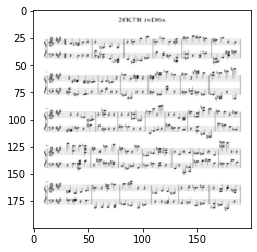

In [66]:
print(sample_score_reloaded.shape)
plt.imshow(gray2rgb(sample_score_reloaded))

In [55]:
bboxes = get_bboxes('sample_score-1.svg')  

(2480, 3508)


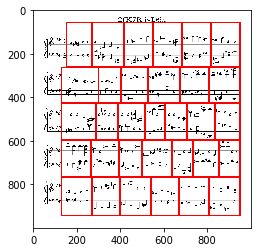

In [42]:
image = Image.open('sample_score-1.png')
print(image.size)
h = 200
w = 200
image = image.resize((w, h))
draw = ImageDraw.Draw(image)
for region in bboxes:
    for bbox in region:
        ((x1, y1), (x2, y2)) = bbox
        bbox = ((x1*w, y1*h), (x2*w, y2*h))
        draw.rectangle(bbox, outline='red', width=5)
image_np = np.array(image)
plt.imshow(image_np, cmap='bone_r')
processed_image = Image.fromarray(image_np)
processed_image.save('saved_image.png')